In [1]:
import pandas as pd
import numpy as np

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.image as immg

# 기본설정

* 코드를 수정하지 말고 실행만 하세요

In [2]:
root_path = "DATASET/"

In [3]:
def plot_image(ax, df, image_name, color='r'):
    try:
        image_group = df.groupby(['file']).get_group(image_name)    
    except:
        return
    path = root_path + 'images/'
    if "missing" in image_name:
        path += 'Missing_hole/'
    if "mouse" in image_name:
        path += 'Mouse_bite/'
    if "open" in image_name:
        path += 'Open_circuit/'
    if "short" in image_name:
        path += 'Short/'
    if "spur" in image_name:
        path += 'Spur/'
    if "spurious" in image_name:
        path += 'Spurious_copper/'
   
    img = immg.imread(path+""+image_name+'.jpg')
    ax.imshow(img,cmap='binary')

    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,facecolor='none',)
        ax.add_patch(rect)    

In [4]:
# Function to calculate IoU
def calculate_iou(box1, box2):
    x1_max = max(box1['xmin'], box2['xmin'])
    y1_max = max(box1['ymin'], box2['ymin'])
    x2_min = min(box1['xmax'], box2['xmax'])
    y2_min = min(box1['ymax'], box2['ymax'])
    
    inter_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)
    
    box1_area = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    box2_area = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])
    
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def evaluate_detection(gt_df, prediction_df, iou_threshold=0.5, check_class=True):

    tp, fp, fn = 0, 0, 0
    gt_grouped = gt_df.groupby('file')
    pred_grouped = prediction_df.groupby('file')

    for file in gt_grouped.groups.keys():
        gt_group = gt_grouped.get_group(file)   # <<<-- 아래 코드를 위치이동
        if file in pred_grouped.groups:
            #gt_group = gt_grouped.get_group(file)  <<<-- 주석처리
            pred_group = pred_grouped.get_group(file)
    

    for file in gt_grouped.groups.keys():
        if file in pred_grouped.groups:
            gt_group = gt_grouped.get_group(file)
            pred_group = pred_grouped.get_group(file)
            
            matched_gt_indices = set()
            matched_pred_indices = set()
            
            for pred_idx, pred in pred_group.iterrows():
                best_iou = 0
                best_gt_idx = -1
                for gt_idx, gt in gt_group.iterrows():
                    if pred['class'] == gt['class'] or not check_class:
                        iou = calculate_iou(pred, gt)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                
                if best_iou >= iou_threshold:
                    if best_gt_idx not in matched_gt_indices:
                        matched_gt_indices.add(best_gt_idx)
                        matched_pred_indices.add(pred_idx)
                        tp += 1
                    else:
                        fp += 1  # Multiple predictions for the same gt box
                else:
                    fp += 1
            
            fn += len(gt_group) - len(matched_gt_indices)
        else:
            fn += len(gt_group)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score
    }


정답 파일 읽어오기

* gt_df 데이터 프레임에는 아래와 같은 불량에 대한 정답 정보가 들어 있습니다.
  * file: 이미지 파일명
  * xmin, ymin, xmax, ymax: 불량 위치에 대한 box 정보
  * class: 불량의 종류 
  * width, height: 이미지의 너비/높이

In [5]:
gt_df = pd.read_csv('gt.csv')
gt_df.head()

,file,xmin,ymin,xmax,ymax,class,width,height
0,10_missing_hole_01,1379,716,1518,834,missing_hole,2240,2016
1,10_missing_hole_01,1930,503,2009,587,missing_hole,2240,2016
2,10_missing_hole_01,1994,660,2088,740,missing_hole,2240,2016
3,10_missing_hole_01,1851,1160,1953,1255,missing_hole,2240,2016
4,10_missing_hole_01,1082,1327,1180,1412,missing_hole,2240,2016


# 구현
이 영역에 코드를 수정하면 됩니다.

구현해야 하는 것은 예측 정보를 담고 있는 데이터 프레임을 생성하는 것입니다.

* gt_df와 동일한 형태의 데이터 프레임으로 예측 정보를 입력하세요.
  * file: 이미지 파일명
  * xmin, ymin, xmax, ymax: 불량 위치에 대한 box 정보
  * class: 불량의 종류 
  * width, height: 입력 안해도 됨

In [6]:
#1. SIFT를 사용하여 원본 이미지를 변환시킨다.

import numpy as np
import cv2 as cv
import os

root_path = "DATASET/"
rotated_image_path = os.path.join(root_path, "images")
output_image_path = os.path.join(root_path, "new_images")

# 원본 이미지 불러오기
clean_images = {}
for img_name in ["10.JPG", "11.JPG", "12.JPG"]:
    img_path = os.path.join(root_path, "clean_images", img_name)
    clean_images[img_name] = cv.imread(img_path, cv.IMREAD_COLOR)

# SIFT 검출기 생성
sift = cv.SIFT_create()

# 키포인트 및 디스크립터 검출
clean_kp_des = {}
for img_name, img in clean_images.items():
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    clean_kp_des[img_name] = (kp, des)

# BFMatcher 생성
bf = cv.BFMatcher()

def find_best_match(rot_img, clean_kp_des):
    gray_rot = cv.cvtColor(rot_img, cv.COLOR_BGR2GRAY)
    kp_rot, des_rot = sift.detectAndCompute(gray_rot, None)
    best_match_img_name = None
    max_inliers = 0
    best_homography = None

    for img_name, (kp_clean, des_clean) in clean_kp_des.items():
        matches = bf.knnMatch(des_clean, des_rot, k=2)
        
        # Ratio Test 적용
        good_matches = []
                for m, n in matches:
                    if m.distance < 0.8 * n.distance:
                        good_matches.append(m)
        
                # 좋은 매칭점이 4개 이상일 경우
                if len(good_matches) > 4:
                    src_pts = np.float32([kp_clean[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
                    dst_pts = np.float32([kp_rot[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
                    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)  # 호모그래피 계산
                    inliers = np.sum(mask)  # inlier 개수 계산
        
                    if inliers > max_inliers:  # 가장 많은 inliers를 가진 매칭 업데이트
                        max_inliers = inliers
                        best_match_img_name = img_name
                        best_homography = H
        
            return best_match_img_name, best_homography  # 최적의 매칭 결과 반환
        
        # 주어진 디렉토리의 이미지를 처리하는 함수
        def process_images_in_directory(directory):
            for root, dirs, files in os.walk(directory):  # 디렉토리 내의 모든 파일 탐색
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # 이미지 파일만 처리
                        rotated_img_path = os.path.join(root, file)  # 이미지 파일 경로
                        rot_img = cv.imread(rotated_img_path, cv.IMREAD_COLOR)  # 이미지 읽기
        
                        if rot_img is None:  # 이미지 읽기에 실패할 경우 건너뜀
                            print(f"Skipping non-image file: {file}")
                            continue
                        
                        # 최적의 매칭 이미지와 호모그래피 계산
                        best_match_img_name, H = find_best_match(rot_img, clean_kp_des) 
                
                if H is not None:
                    height, width, _ = rot_img.shape  # 회전된 이미지의 크기를 기준으로 설정
                    # 원본 이미지를 회전된 이미지와 같은 변환 행렬 H로 회전
                    rotated_clean_img = cv.warpPerspective(clean_images[best_match_img_name], H, (width, height), borderMode=cv.BORDER_CONSTANT, borderValue=(255, 255, 255))
                    
                    output_img_path = os.path.join(output_image_path, file)
                    
                    # 폴더가 존재하지 않으면 생성
                    os.makedirs(output_image_path, exist_ok=True)
                    
                    cv.imwrite(output_img_path, rotated_clean_img)
                    print(f"{file} is matched with {best_match_img_name} and rotated.")
                else:
                    print(f"Failed to find a match for {file}.")
            else:
                print(f"Skipping non-image file: {file}")

# 회전된 이미지 폴더 처리
process_images_in_directory(rotated_image_path)


In [7]:
#2. 변환한 원본 이미지와 오류 이미지를 이진화시킨다.

import cv2
import numpy as np
import os

# 이미지 파일 경로
root_path = "DATASET/"
image_path = os.path.join(root_path, "images")
output_path = os.path.join(root_path, "BandW_images")

# 폴더가 존재하지 않으면 생성
os.makedirs(output_path, exist_ok=True)

# 이미지 처리
for root, dirs, files in os.walk(image_path):
    for file in files:
        # 파일 확장자가 이미지 형식인지 확인
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # 이미지 파일 읽기
            img = cv2.imread(os.path.join(root, file))
            
            if img is None:
                print(f"Skipping non-image file: {file}")
                continue
            
            # 흑백 이미지로 변환
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # 이진화
            _, binary = cv2.threshold(gray, 43, 255, cv2.THRESH_BINARY)
            
            # 경로
            output_file_path = os.path.join(output_path, file)
            
            # 이미지 저장
            cv2.imwrite(output_file_path, binary)
           
        else:
            print(f"Skipping non-image file: {file}")

print("Processing completed.")


In [8]:
#2. 변환한 원본 이미지와 오류 이미지를 이진화시킨다.

import cv2
import numpy as np
import os

# 이미지 파일 경로
root_path = "DATASET/"
image_path = os.path.join(root_path, "new_images")
output_path = os.path.join(root_path, "BAW_images")

# 폴더가 존재하지 않으면 생성
os.makedirs(output_path, exist_ok=True)

# 이미지 처리
for root, dirs, files in os.walk(image_path):
    for file in files:
        # 파일 확장자가 이미지 형식인지 확인
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # 이미지 파일 읽기
            img = cv2.imread(os.path.join(root, file))
            
            if img is None:
                print(f"Skipping non-image file: {file}")
                continue
            
            # 흑백 이미지로 변환
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # 이진화
            _, binary = cv2.threshold(gray, 43, 255, cv2.THRESH_BINARY)
            
            # 경로
            output_file_path = os.path.join(output_path, file)
            
            # 이미지 저장
            cv2.imwrite(output_file_path, binary)
            
        else:
            print(f"Skipping non-image file: {file}")

print("Processing completed.")


In [9]:
#3. 이진화한 이미지를 차 연산한다.

import cv2
import numpy as np
import os

# 이미지 파일 경로
root_path = "DATASET/"
first_image_path = os.path.join(root_path, "images")
second_image_path = os.path.join(root_path, "new_images")
output_path = os.path.join(root_path, "Difference_images")

# 폴더가 존재하지 않으면 생성
os.makedirs(output_path, exist_ok=True)

# 이미지 처리
first_image_files = sorted([file for file in os.listdir(first_image_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
second_image_files = sorted([file for file in os.listdir(second_image_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])

for file1, file2 in zip(first_image_files, second_image_files):
    # 이미지 파일 읽기
    img1 = cv2.imread(os.path.join(first_image_path, file1), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(os.path.join(second_image_path, file2), cv2.IMREAD_GRAYSCALE)
    
    if img1 is None or img2 is None:
        print(f"Skipping non-image file: {file1} or {file2}")
        continue
    
    # 이미지 크기가 다를 경우 크기를 맞춤
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    # 이진화
    _, binary1 = cv2.threshold(img1, 43, 255, cv2.THRESH_BINARY)
    _, binary2 = cv2.threshold(img2, 43, 255, cv2.THRESH_BINARY)
    
    # 차연산
    diff = cv2.absdiff(binary1, binary2)
    
    # 경로
    output_file_path = os.path.join(output_path, file1)
    
    # 이미지 저장
    cv2.imwrite(output_file_path, diff)
    print(f"Processed {file1} and {file2}")

print("Processing completed.")


In [10]:
#4. 차 연산한 이미지에 오픈 연산을 수행한다.

import cv2
import numpy as np
import os

# 이미지 파일 경로
root_path = "DATASET/"
input_image_path = os.path.join(root_path, "Difference_images")
output_image_path = os.path.join(root_path, "Dilated_images")

# 폴더가 존재하지 않으면 생성
os.makedirs(output_image_path, exist_ok=True)

# 커널 크기 정의 (원 형태의 커널)
kernel_size = (8, 8)

# 이미지 처리
for root, dirs, files in os.walk(input_image_path):
    for file in files:
        # 파일 확장자가 이미지 형식인지 확인
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # 이미지 파일 읽기
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Skipping non-image file: {file}")
                continue
            
            # 커널 생성 (원 형태)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
            
            # 오픈 연산 수행
            opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
            
            # 경로
            output_file_path = os.path.join(output_image_path, file)
            
            # 이미지 저장
            cv2.imwrite(output_file_path, opened)
            
        else:
            print(f"Skipping non-image file: {file}")

print("Processing completed.")


In [11]:
#5. 오픈 연산한 이미지에 팽창 연산을 수행한다.

import cv2
import numpy as np
import os

# 이미지 파일 경로
root_path = "DATASET/"
input_image_path = os.path.join(root_path, "Dilated_images")
new_output_image_path = os.path.join(root_path, "boom_images")  # 새로운 저장 경로

# 새로운 폴더가 존재하지 않으면 생성
os.makedirs(new_output_image_path, exist_ok=True)

# 커널 크기 정의 (원 형태의 커널)
kernel_size = (15, 15)

# 이미지 처리
for root, dirs, files in os.walk(input_image_path):
    for file in files:
        # 파일 확장자가 이미지 형식인지 확인
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # 이미지 파일 읽기
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Skipping non-image file: {file}")
                continue
            
            # 커널 생성 (원 형태)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
            
            # 팽창 연산 수행
            dilated = cv2.dilate(img, kernel)
            
            # 경로
            output_file_path = os.path.join(new_output_image_path, file)
            
            # 이미지 저장
            cv2.imwrite(output_file_path, dilated)
            
        else:
            print(f"Skipping non-image file: {file}")

print("Processing completed.")


In [12]:
# 6. 최종 이미지를 가지고 박스 플롯을 그린다.

import cv2
import numpy as np
import os
import shutil
import pandas as pd

# 이미지 파일 경로
root_path = "DATASET/"
input_image_path = os.path.join(root_path, "boom_images")
output_image_path = os.path.join(root_path, "Bounding_box_images")
original_image_path = os.path.join(root_path, "im")  # 원본 이미지를 복사한 파일 이름

# 폴더가 존재하지 않으면 생성
os.makedirs(output_image_path, exist_ok=True)

# 커널 크기 정의 (원 형태의 커널)
kernel_size = (18, 16)

# 바운딩 박스 크기 조정 값
bbox_increase = 17  # 바운딩 박스를 확장할 픽셀 수

# 바운딩 박스 정보 저장을 위한 리스트
bounding_boxes = []

# 이미지 처리
for root, dirs, files in os.walk(input_image_path):
    for file in files:
        # 파일 확장자가 이미지 형식인지 확인
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # boom_images에서 이미지 파일 읽기
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Skipping non-image file: {file}")
                continue
            
            # 커널 생성 (원 형태)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
            
            # 오픈 연산 수행
            opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
            
            # contours 찾기
            contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # 원본 이미지를 복사하여 바운딩 박스를 그릴 이미지 생성
            original_img_path = os.path.join(original_image_path, file)
            copy_img_path = os.path.join(output_image_path, file)
            
            # 복사할 디렉토리가 존재하지 않으면 생성
            os.makedirs(output_image_path, exist_ok=True)
            
            shutil.copyfile(original_img_path, copy_img_path)
            img_with_bbox = cv2.imread(copy_img_path)  # 복사한 이미지를 BGR로 읽기
            
            if img_with_bbox is None:
                print(f"Skipping non-image file: {original_img_path}")
                continue
            
            # 바운딩 박스 그리기 및 정보 저장
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                
                # 바운딩 박스 크기 증가
                x = max(0, x - bbox_increase)
                y = max(0, y - bbox_increase)
                w = min(img_with_bbox.shape[1] - x, w + 2 * bbox_increase)
                h = min(img_with_bbox.shape[0] - y, h + 2 * bbox_increase)
                
                cv2.rectangle(img_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
                # 클래스 분류 (클래스 열도 생성하기 위해 아무렇게나 클래스 열 생성)
                if "missing" in file.lower():
                    cls = "missing_hole"
                elif "mouse" in file.lower():
                    cls = "mouse_bite"
                elif "open" in file.lower():
                    cls = "open_circuit"
                elif "short" in file.lower():
                    cls = "short"
                else:
                    cls = "Unknown"  # 클래스 분류가 안되는 경우
                
                # 바운딩 박스 정보 저장 (확장자 제거하여 저장)
                bounding_boxes.append([file[:-4], x, y, x + w, y + h, cls])
            
            # 이미지 저장
            cv2.imwrite(copy_img_path, img_with_bbox)
            
        else:
            print(f"Skipping non-image file: {file}")

# 데이터프레임으로 바운딩 박스 정보 저장
columns = ['file', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
bounding_boxes_df = pd.DataFrame(bounding_boxes, columns=columns)

# 결과를 CSV 파일로 저장
bounding_boxes_df.to_csv(os.path.join(root_path, 'bounding_boxes.csv'), index=False)
print("Bounding boxes saved to bounding_boxes.csv")

print("Processing completed.")



Processed 11_missing_hole_07.jpg
Processed 11_mouse_bite_06.jpg
Processed 12_missing_hole_05.jpg
Processed 12_missing_hole_04.jpg
Processed 12_missing_hole_10.jpg
Processed 11_mouse_bite_07.jpg
Processed 11_missing_hole_06.jpg
Processed 10_mouse_bite_01.jpg
Processed 10_missing_hole_05.jpg
Processed 10_mouse_bite_03.jpg
Processed 11_missing_hole_04.jpg
Processed 11_mouse_bite_05.jpg
Processed 11_missing_hole_10.jpg
Processed 12_missing_hole_06.jpg
Processed 12_missing_hole_07.jpg
Processed 11_mouse_bite_10.jpg
Processed 10_mouse_bite_02.jpg
Processed 11_mouse_bite_04.jpg
Processed 11_missing_hole_05.jpg
Processed 10_missing_hole_04.jpg
Processed 11_missing_hole_01.jpg
Processed 12_missing_hole_03.jpg
Processed 12_missing_hole_02.jpg
Processed 11_mouse_bite_01.jpg
Processed 10_missing_hole_01.jpg
Processed 10_missing_hole_03.jpg
Processed 10_mouse_bite_05.jpg
Processed 11_missing_hole_02.jpg
Processed 11_mouse_bite_03.jpg
Processed 12_missing_hole_01.jpg
Processed 10_mouse_bite_04.jpg
P

In [13]:
# 7. 박스 안 이미지 가져오기

import cv2
import numpy as np
import os
import shutil
import random

# 이미지 파일 경로
root_path = "DATASET/"
input_image_path = os.path.join(root_path, "boom_images")
output_image_path = os.path.join(root_path, "Cropped_images")
original_image_path = os.path.join(root_path, "im")  # 원본 이미지가 있는 경로

# 폴더가 존재하지 않으면 생성
os.makedirs(output_image_path, exist_ok=True)

# 커널 크기 정의 (원 형태의 커널)
kernel_size = (18, 16)

# 바운딩 박스 크기 조정 값
bbox_increase = 17  # 바운딩 박스를 확장할 픽셀 수

# 이미지 처리
for root, dirs, files in os.walk(input_image_path):
    for file in files:
        # 파일 확장자가 이미지 형식인지 확인
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # boom_images에서 이미지 파일 읽기
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Skipping non-image file: {file}")
                continue
            
            # 커널 생성 (원 형태)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
            
            # 오픈 연산 수행
            opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
            
            # contours 찾기
            contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if len(contours) == 0:
                print(f"No contours found in image: {file}")
                continue
            
            # 원본 이미지를 읽기
            original_img_path = os.path.join(original_image_path, file)
            original_img = cv2.imread(original_img_path)
            
            if original_img is None:
                print(f"Skipping non-image file: {original_img_path}")
                continue
            
            # 랜덤하게 바운딩 박스 하나 선택
            contour = random.choice(contours)
            x, y, w, h = cv2.boundingRect(contour)
            
            # 바운딩 박스 크기 증가
            x = max(0, x - bbox_increase)
            y = max(0, y - bbox_increase)
            w = min(original_img.shape[1] - x, w + 2 * bbox_increase)
            h = min(original_img.shape[0] - y, h + 2 * bbox_increase)
            
            # 바운딩 박스 내의 이미지 잘라내기
            cropped_img = original_img[y:y+h, x:x+w]
            
            # 잘라낸 이미지 저장 경로
            cropped_img_path = os.path.join(output_image_path, f"cropped_{file}")
            
            # 이미지 저장
            cv2.imwrite(cropped_img_path, cropped_img)
            
        else:
            print(f"Skipping non-image file: {file}")

print("Processing completed.")


Cropped and saved 11_missing_hole_07.jpg
Cropped and saved 11_mouse_bite_06.jpg
Cropped and saved 12_missing_hole_05.jpg
Cropped and saved 12_missing_hole_04.jpg
Cropped and saved 12_missing_hole_10.jpg
Cropped and saved 11_mouse_bite_07.jpg
Cropped and saved 11_missing_hole_06.jpg
Cropped and saved 10_mouse_bite_01.jpg
Cropped and saved 10_missing_hole_05.jpg
Cropped and saved 10_mouse_bite_03.jpg
Cropped and saved 11_missing_hole_04.jpg
Cropped and saved 11_mouse_bite_05.jpg
Cropped and saved 11_missing_hole_10.jpg
Cropped and saved 12_missing_hole_06.jpg
Cropped and saved 12_missing_hole_07.jpg
Cropped and saved 11_mouse_bite_10.jpg
Cropped and saved 10_mouse_bite_02.jpg
Cropped and saved 11_mouse_bite_04.jpg
Cropped and saved 11_missing_hole_05.jpg
Cropped and saved 10_missing_hole_04.jpg
Cropped and saved 11_missing_hole_01.jpg
Cropped and saved 12_missing_hole_03.jpg
Cropped and saved 12_missing_hole_02.jpg
Cropped and saved 11_mouse_bite_01.jpg
Cropped and saved 10_missing_hole_

In [15]:
# 8. 바운딩 박스 안 이미지 분류
# 추가 설명 : - 이미지 데이터셋을 클러스터링하고 분류
#           - SIFT(Speeded-Up Robust Features)를 사용하여 각 이미지의 특징을 추출
#           - K-평균 클러스터링을 사용하여 특징들을 클러스터링 후, 각 이미지에 대한 히스토그램을 생성하여 가장 큰 값의 인덱스를 기반으로 이미지를 분류 
#           - 분류 결과를 CSV 파일로 저장
    
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# 경로 설정
root_path = "DATASET/"
cropped_image_path = os.path.join(root_path, "Cropped_images")

# 클래스 정의
classes = ['missing_hole', 'mouse_bite', 'open_circuit', 'short']
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

# SIFT 생성
sift = cv2.SIFT_create()

# 특징점과 라벨을 저장할 리스트
descriptors = []
image_paths = []

# 이미지 처리
for root, dirs, files in os.walk(cropped_image_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # 이미지 파일 읽기
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Skipping non-image file: {file}")
                continue
            
            # SIFT 특징점 추출
            keypoints, des = sift.detectAndCompute(img, None)
            
            if des is not None:
                descriptors.append(des)
                image_paths.append(img_path)

# K-means를 사용하여 특징점 군집화
num_clusters = len(classes)
kmeans = KMeans(n_clusters=num_clusters)
all_descriptors = np.vstack(descriptors)
kmeans.fit(all_descriptors)

# 각 이미지에 대한 히스토그램을 생성
image_histograms = []
for des in descriptors:
    histogram = np.zeros(num_clusters)
    cluster_result = kmeans.predict(des)
    for cluster in cluster_result:
        histogram[cluster] += 1
    image_histograms.append(histogram)

# 이미지 분류
classified_results = []
for histogram in image_histograms:
    # 가장 큰 값의 인덱스를 찾아서 클래스로 사용
    predicted_class_idx = np.argmax(histogram)
    predicted_class = classes[predicted_class_idx]
    classified_results.append(predicted_class)

# 결과를 CSV 파일로 저장
results = pd.DataFrame({'file': image_paths, 'predicted_class': classified_results})
results.to_csv(os.path.join(root_path, 'classified_images.csv'), index=False)
print("Classified images saved to classified_images.csv")

print("Processing completed.")


Classified images saved to classified_images.csv
Processing completed.


In [23]:
# 9. 데이터 전처리

import pandas as pd
import os

# 경로 설정
root_path = "DATASET/"
classified_images_file = os.path.join(root_path, 'classified_images.csv')

# CSV 파일 읽기
df = pd.read_csv(classified_images_file)

# 파일 열에서 'DATASET/Cropped_images/cropped_' 부분 삭제
df['file'] = df['file'].str.replace('DATASET/Cropped_images/cropped_', '', regex=False)
df['file'] = df['file'].str.replace('.jpg', '')

# 수정된 DataFrame을 새로운 CSV 파일로 저장
modified_classified_images_file = os.path.join(root_path, 'classified_images.csv')
df.to_csv(modified_classified_images_file, index=False)

print("Modified classified images saved to", modified_classified_images_file)


Modified classified images saved to DATASET/classified_images.csv


/var/folders/46/9ry5zmpj49sbvm_g_1tt2z600000gn/T/ipykernel_9762/1409033499.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['file'] = df['file'].str.replace('.jpg', '')


In [24]:
# 10. 데이터 전처리 2

import pandas as pd
import os

# 파일 경로 설정
root_path = "DATASET/"
bounding_boxes_file = os.path.join(root_path, 'bounding_boxes.csv')
classified_images_file = os.path.join(root_path, 'classified_images.csv')

# CSV 파일 읽기
bounding_boxes_df = pd.read_csv(bounding_boxes_file)
classified_images_df = pd.read_csv(classified_images_file)

# 파일 이름에서 확장자를 제외한 부분을 찾아 기준 열로 사용
bounding_boxes_df['file_name'] = bounding_boxes_df['file'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
classified_images_df['file_name'] = classified_images_df['file'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# 파일명을 기준으로 두 데이터프레임 병합
combined_df = pd.merge(bounding_boxes_df, classified_images_df[['file_name', 'predicted_class']], on='file_name', how='left')

# 결과를 CSV 파일로 저장
output_file = os.path.join(root_path, 'combined_data.csv')
combined_df.drop(columns=['file_name'], inplace=True)  # 중복되는 열 삭제
combined_df.to_csv(output_file, index=False)

print("Combined data saved to combined_data.csv")


Combined data saved to combined_data.csv


(예시) 아래와 같이 각 이미지 파일에 대해서 불량의 위치와 class정보를 포함하는 예측 데이터 프레임(pred_df)을 생성하면 됩니다.

In [25]:
# 11. pred_df 지정

bounding_boxes_with_class_file = "DATASET/combined_data.csv"

# CSV 파일 읽기
pred_df = pd.read_csv(bounding_boxes_with_class_file)

In [26]:
# 12. pred_df 열 삭제 및 이름 변경

pred_df = pred_df.drop("class",axis =1)
pred_df = pred_df.rename(columns= {'predicted_class':'class'})

In [27]:
pred_df

,file,xmin,ymin,xmax,ymax,class
0,11_missing_hole_07,803,1947,872,2015,short
1,11_missing_hole_07,913,1945,985,2007,short
2,11_missing_hole_07,561,1057,640,1135,short
3,11_missing_hole_07,1378,1017,1457,1096,short
4,11_missing_hole_07,1204,801,1281,872,short
...,...,...,...,...,...,...
507,12_missing_hole_08,841,2010,911,2080,missing_hole
508,12_missing_hole_08,2250,1865,2318,1934,missing_hole
509,12_missing_hole_08,482,1068,545,1136,missing_hole
510,12_missing_hole_08,625,715,697,782,missing_hole


(예시 Visualizaion) 파일명을 설정하면 아래 그림과 같이 검출된 결과와 정답을 확인할 수 있습니다.

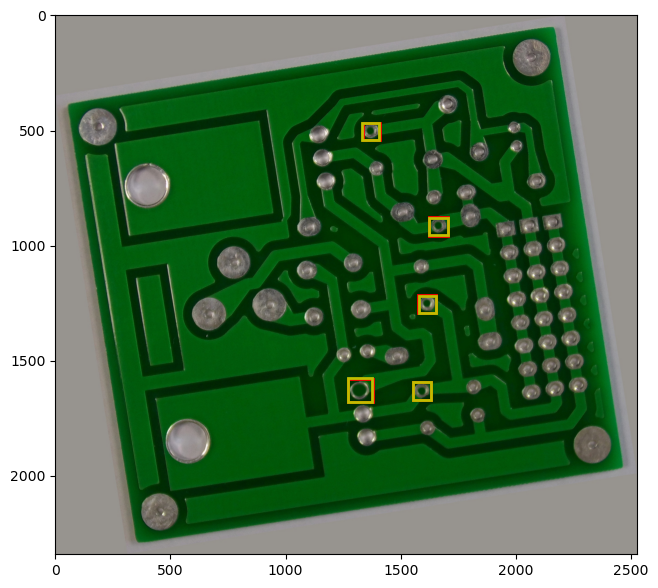

In [28]:
name = '10_missing_hole_03'
fig, ax = plt.subplots(figsize=(12,7))
plot_image(ax, gt_df, name, 'r')
plot_image(ax, pred_df, name, 'y')
plt.show()

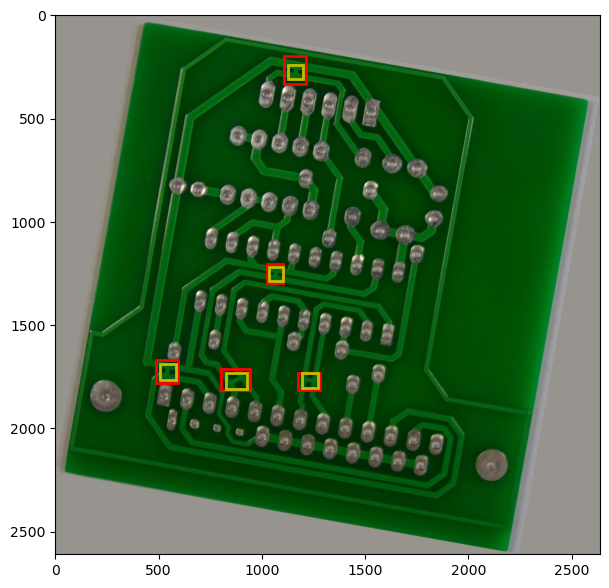

In [29]:
name2 = '11_short_05'
fig, ax = plt.subplots(figsize=(12,7))
plot_image(ax, gt_df, name2, 'r')
plot_image(ax, pred_df, name2, 'y')
plt.show()

랜덤하게 이미지 선택해서 결과 표시하는 코드

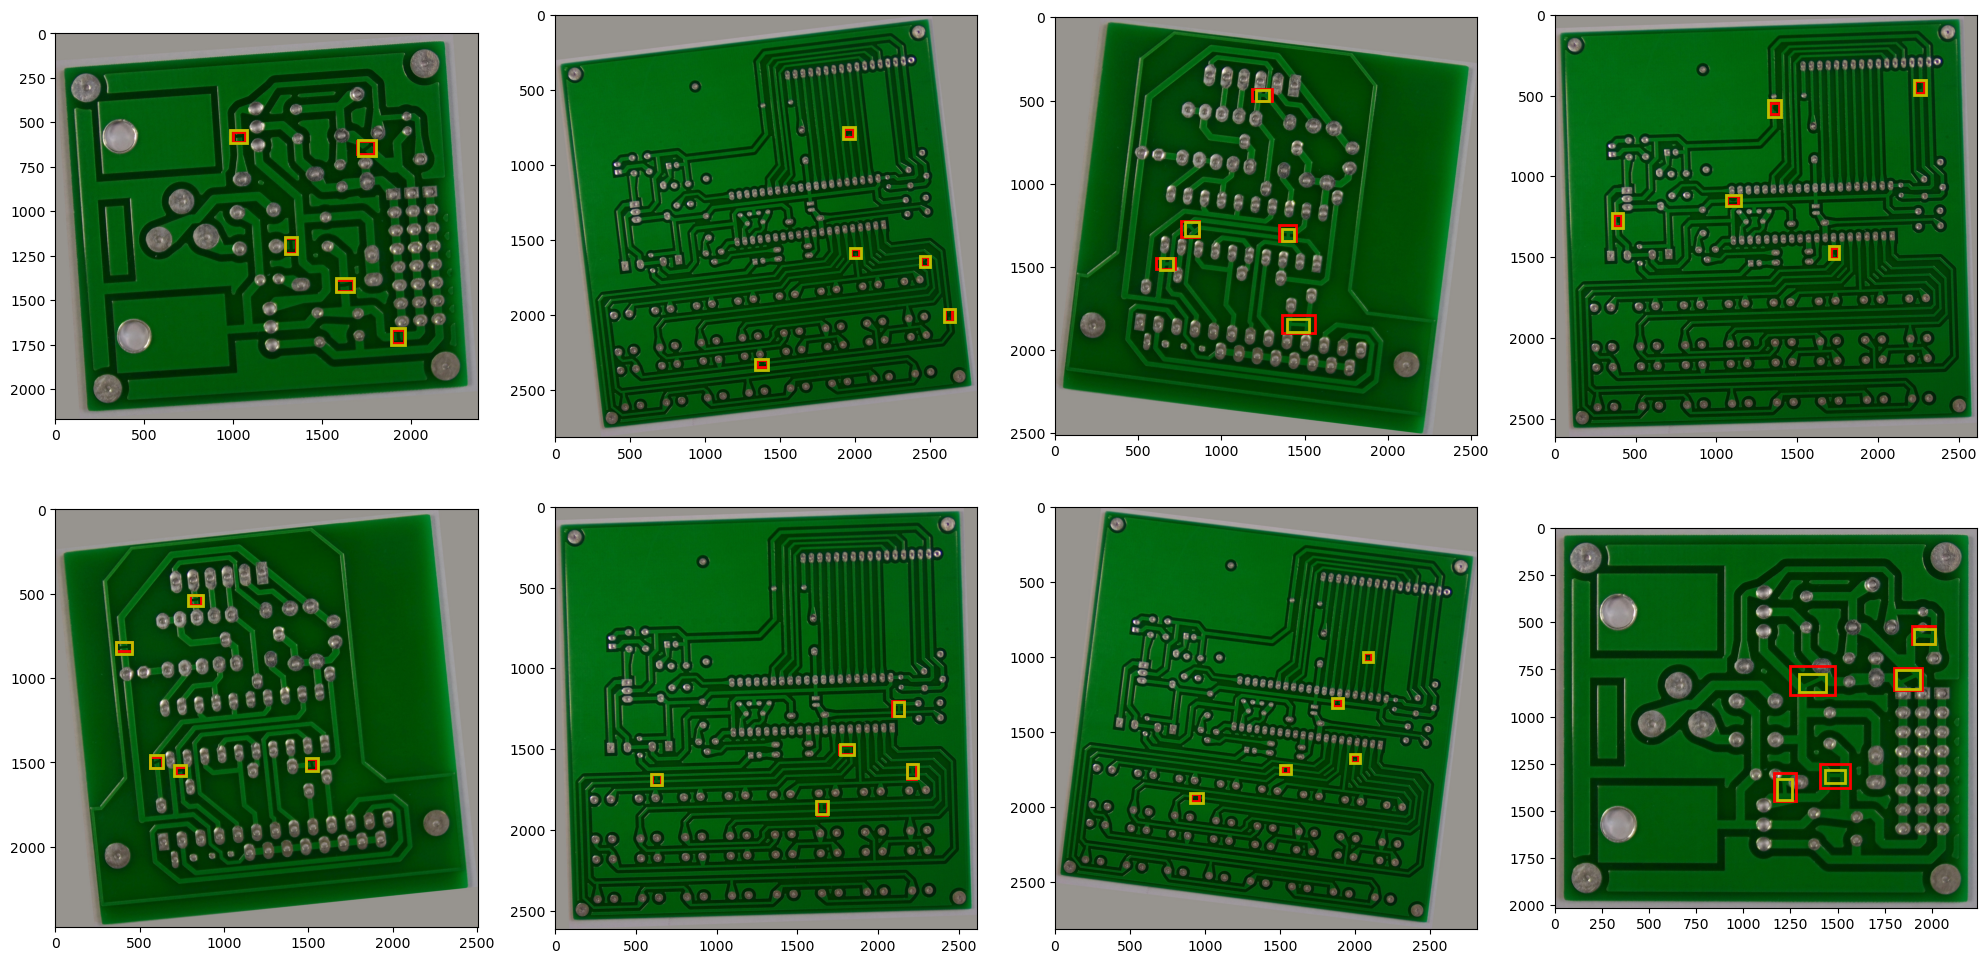

In [30]:
names = np.random.choice(gt_df.file.unique(), 8)
fig, ax = plt.subplots(2,4, figsize=(20,10))

k = 0
for i in range(2):
    for j in range(4):
        plot_image(ax[i][j], gt_df, names[k], 'r')
        plot_image(ax[i][j], pred_df, names[k], 'y')
        k += 1
plt.tight_layout()
plt.show()

# 평가

* 코드 수정은 하지말고 실행만 하세요.
* 평가는 2가지에 대해서 수행합니다.
  1. class와 무관하게 불량 위치를 찾았는지를 평가
  2. class까지 정확하게 맞추었는지를 평가

In [31]:
# Class상관없이 불량 위치를 제대로 찾았는지에 대한 평가
evaluate_detection(gt_df, pred_df, check_class=False)

{'True Positives': 463,
 'False Positives': 49,
 'False Negatives': 47,
 'Precision': 0.904296875,
 'Recall': 0.907843137254902,
 'F1-score': 0.9060665362035225}

In [32]:
# class까지 정확하게 맞춘 성능을 평가
evaluate_detection(gt_df, pred_df, check_class=True)

{'True Positives': 162,
 'False Positives': 350,
 'False Negatives': 348,
 'Precision': 0.31640625,
 'Recall': 0.3176470588235294,
 'F1-score': 0.31702544031311153}